In [1]:
!pip install yfinance tensorflow scikit-learn numpy pandas matplotlib

## Import Necessary Libraries

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, InputLayer
from sklearn.metrics import mean_squared_error

## Download Data

In [2]:
ticker = "AAPL"
data = yf.download(ticker, start="2010-01-01", end="2023-10-26")

# Usev 'Close' for price prediction
data = data['Close']
data = pd.DataFrame(data)

[*********************100%***********************]  1 of 1 completed


In [3]:
print(data.sample(5))

Ticker            AAPL
Date                  
2022-11-11  148.142151
2012-05-04   17.029112
2023-09-18  176.869354
2022-09-23  148.618027
2015-05-27   29.643919


## Data Preprocessing

In [4]:
## Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)

In [16]:
## Create Sequences for LSTM
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)


In [6]:
seq_length = 30 # No. of days to look back
X, y = create_sequences(scaled_data, seq_length)

In [7]:
# Check if there is enough data
if len(X) <= 1: # Check if there is enough data for train/test split
    raise ValueError("Not enough data after creating sequences. Increase data range or reduce sequence length.")

In [17]:
## Splitting data into training and testing sets
train_size = int(len(X) * 0.8)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

if len(X_train) == 0 or len(X_test) == 0 or len(y_train) == 0 or len(y_test) == 0:
    raise ValueError("One of the training or testing sets is empty. Adjust train/test split ratio or data range.")

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


trend_data = np.array(range(len(scaled_data))).reshape(-1, 1)
trend_data_train = trend_data[:train_size]
trend_data_test = trend_data[train_size:train_size + len(X_test)]

## Build and Train LSTM Model

In [18]:
lstm_model = Sequential()

lstm_model.add(InputLayer(input_shape=(X_train.shape[1], 1)))
lstm_model.add(LSTM(50, return_sequences=True))
lstm_model.add(LSTM(50))
lstm_model.add(Dense(1))

lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train, y_train, epochs=25, batch_size=32, verbose=0)
lstm_predictions = lstm_model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


## Build & Train Linear Regression Model

In [19]:
linear_model = LinearRegression()
linear_model.fit(trend_data_train, scaled_data[:train_size].reshape(-1,1))
linear_predictions = linear_model.predict(trend_data_test)

## Hybrid Model

In [20]:
lstm_predictions = lstm_predictions.reshape(-1, 1)
linear_predictions = linear_predictions.reshape(-1,1)

combined_predictions = np.concatenate((lstm_predictions, linear_predictions), axis=1)

y_test = y_test.reshape(-1,1)

final_model = LinearRegression()
final_model.fit(combined_predictions, y_test)
hybrid_predictions = final_model.predict(combined_predictions)


## Evaluating

In [21]:
y_test = scaler.inverse_transform(y_test)

lstm_predictions = scaler.inverse_transform(lstm_predictions)
linear_predictions = scaler.inverse_transform(linear_predictions)
hybrid_predictions = scaler.inverse_transform(hybrid_predictions)

lstm_rmse = np.sqrt(mean_squared_error(y_test, lstm_predictions))
linear_rmse = np.sqrt(mean_squared_error(y_test, linear_predictions))
hybrid_rmse = np.sqrt(mean_squared_error(y_test, hybrid_predictions))


print(f"LSTM RMSE: {lstm_rmse}")
print(f"Linear Regression RMSE: {linear_rmse}")
print(f"Hybrid RMSE: {hybrid_rmse}")

LSTM RMSE: 5.829243744359216
Linear Regression RMSE: 79.56339904759736
Hybrid RMSE: 3.4457020872479442


## Plotting

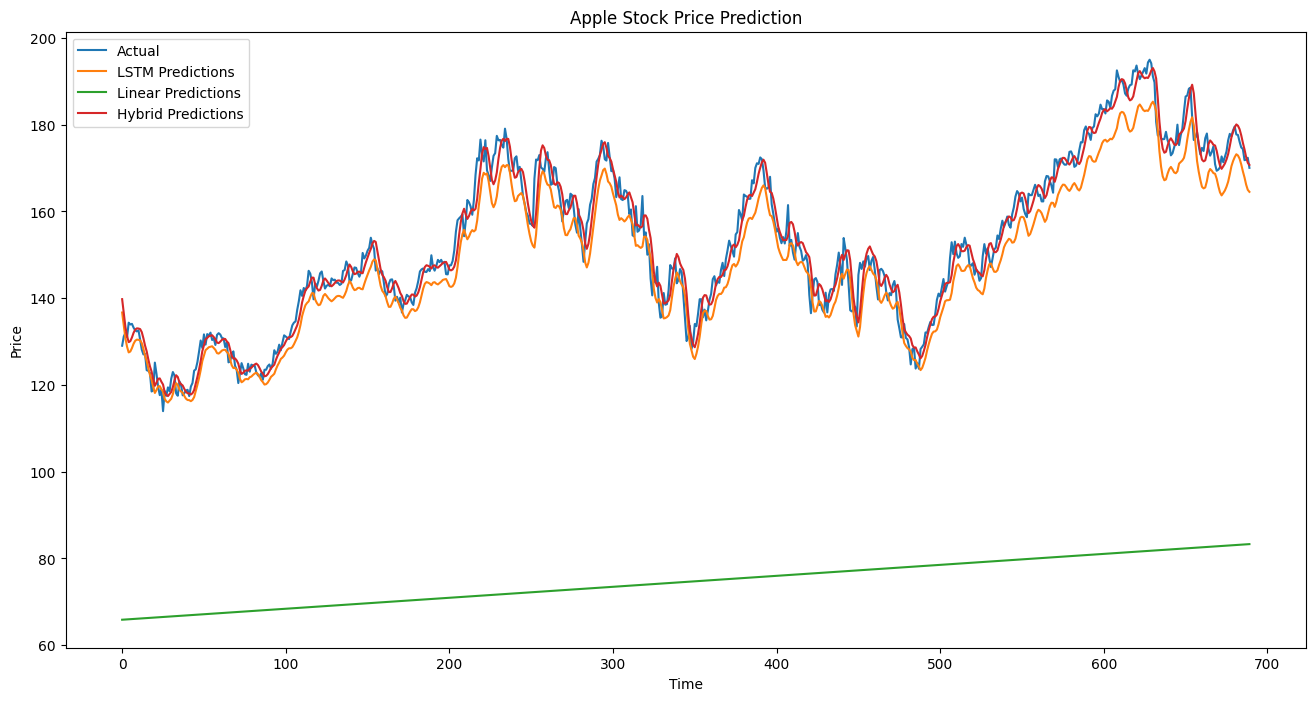

In [22]:
plt.figure(figsize=(16, 8))
plt.plot(y_test, label='Actual')
plt.plot(lstm_predictions, label='LSTM Predictions')
plt.plot(linear_predictions, label='Linear Predictions')
plt.plot(hybrid_predictions, label='Hybrid Predictions')
plt.title('Apple Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()
